In [32]:
import pyneuralnet as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from typing import List, Any
np.random.seed(123)

In [33]:
class Data(nn.abstract.DataSource2D):
    _train_in : List[Any]
    _train_out : List[Any]

    def __init__(self):
        super().__init__()
        train_in, _ = pickle.load(open('data/mnist_preprocessed.pickle', 'rb'))
        self._train_in = [np.reshape(x, (28,28,1)) for x in train_in]
        self._train_out = [np.reshape(x, (28,28,1)) for x in train_in]

    def size(self):
        return 1

    def sample(self, i : int):
        idx = np.random.randint(0, len(self._train_in)-1)
        return (self._train_in[idx], self._train_out[idx])

class Model(nn.abstract.Model):
    def __init__(self):
        super().__init__()
        self._pool = nn.convolution.MaxPoolEncoder2D()
        self._layer1 = nn.convolution.Conv2D(1,3, 0.9,0.999)
        # self._layer2 = nn.convolution.MaxPool2D()
        self._layer3 = nn.convolution.Conv2D(3,3, 0.9,0.999)
        # self._layer4 = nn.convolution.MaxUnPool2D(self._layer2)
        self._layer5 = nn.convolution.Conv2D(3,1, 0.9,0.999)
        self._layer6 = nn.convolution.Sigmoid2D()
    
    def forward(self, input):
        return  self._layer6.forward(
                    self._layer5.forward(
                        self._pool.decode(
                            self._layer3.forward(
                                self._pool.encode(
                                    self._layer1.forward(input)
                                )
                            )
                        )
                    )
                )
    
    def backward(self, error):
        return  self._layer1.backward(
                    self._pool.backward_encode(
                        self._layer3.backward(
                            self._pool.backward_decode(
                                self._layer5.backward(
                                    self._layer6.backward(error)
                                )
                            )
                        )
                    )
                )
    
    def update(self, rate):
        self._layer1.update(rate)
        self._layer3.update(rate)
        self._layer5.update(rate)
        self._layer6.update(rate)
    

In [34]:
N = 100
a = 0.000001

In [35]:
model = nn.compound.Sequence(
    nn.compound.UNet(1, 0.6, 0.9, 0.999, True),
    nn.convolution.Conv2D(2, 1, 0.9, 0.999),
    nn.convolution.Sigmoid2D()
)
data = Data()
loss = nn.loss.L2()
trainer = nn.training.Trainer2D(model, data, loss)

In [36]:
sample = data.sample(0)

In [37]:
sample[0].shape

(28, 28, 1)

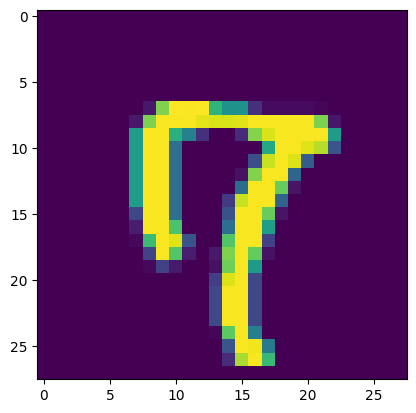

In [38]:
plt.imshow(sample[0])

(28, 28, 1)

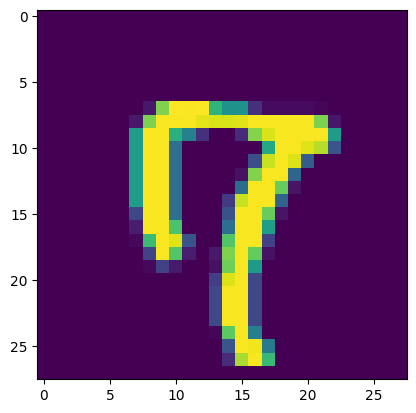

In [39]:
plt.imshow(sample[1])
sample[1].shape

In [ ]:
plt.imshow(model.forward(sample[1]))
sample[1].shape

Training of model complete in 0.005280919075012207 seconds per epoch, 5.280919075012207 milliseconds per sample.


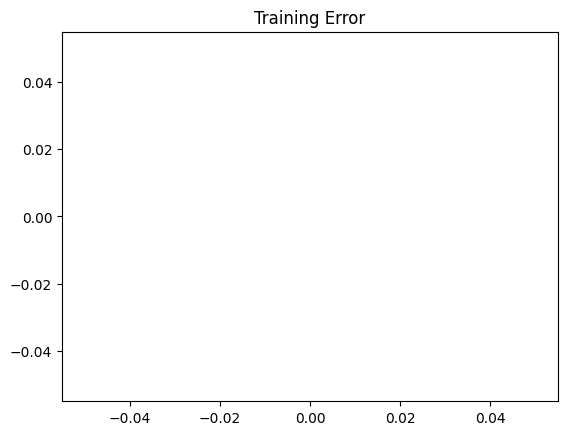

In [40]:
ts = time.time()
errors = trainer.train(N, a)
duration = time.time() - ts
print(f"Training of model complete in {duration / N} seconds per epoch, {duration * 1000 / (N * data.size())} milliseconds per sample.")

plt.title("Training Error")
plt.plot(range(len(errors)), errors)
plt.show()

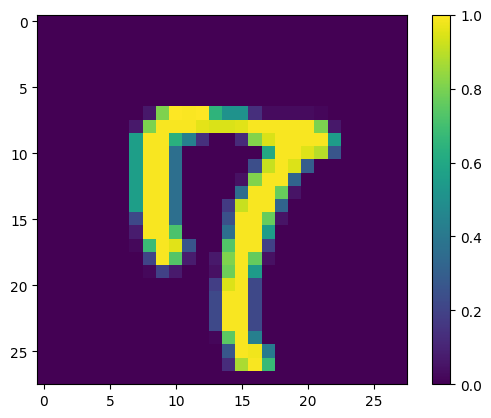

In [41]:
plt.imshow(sample[0])
plt.colorbar()

In [42]:
out = model.forward(sample[0])
out.shape

(28, 28, 1)

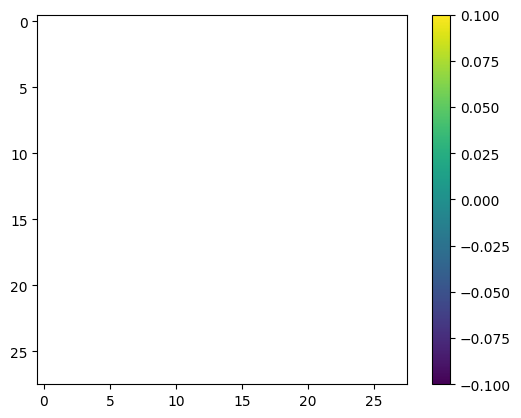

In [43]:
plt.imshow(out)
plt.colorbar()

In [44]:
import pickle

bts = pickle.dumps(model)
sour_model = pickle.loads(bts)
out1 = model.forward(data.sample(0)[0])
out2 = sour_model.forward(data.sample(0)[0])
diff = abs(out1 - out2)
print(f"{np.min(diff)} - {np.mean(diff)} - {np.max(diff)}")

IndexError: tuple index out of range